=== Evaluation Report ===
Train Accuracy: 0.8734
Test Accuracy: 0.9000
Train ROC AUC: 0.9316
Test ROC AUC: 0.9268
Best Threshold: 0.2633
Precision: 0.7333
Recall: 0.8919
F1 Score: 0.8049

              precision    recall  f1-score   support

      No ASD       0.97      0.90      0.93       123
         ASD       0.73      0.89      0.80        37

    accuracy                           0.90       160
   macro avg       0.85      0.90      0.87       160
weighted avg       0.91      0.90      0.90       160



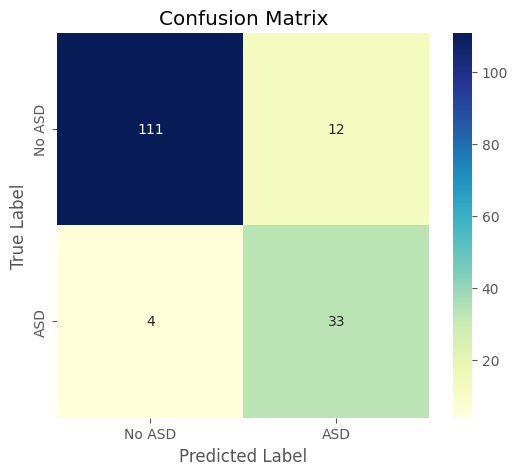

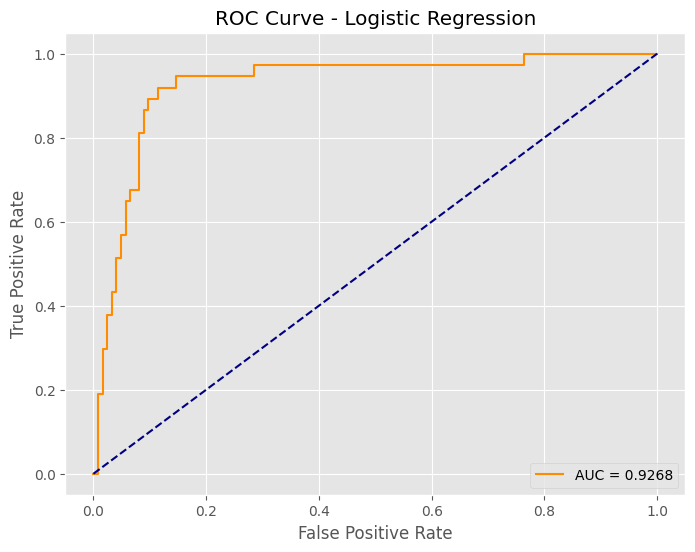

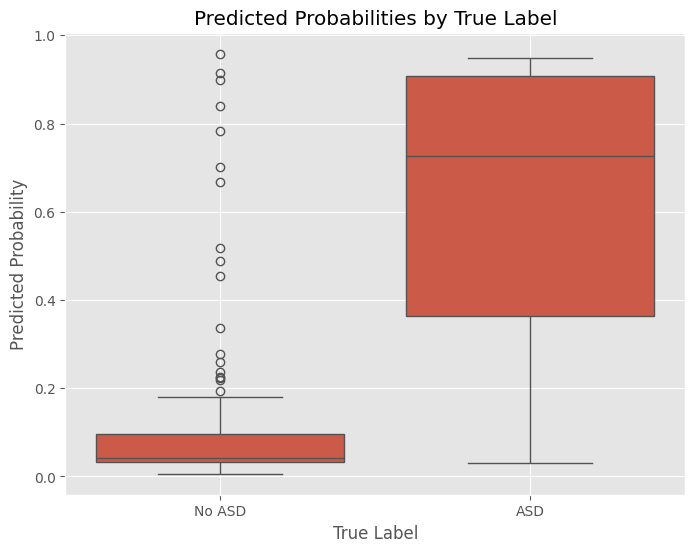

In [2]:
# ================================
# COMPLETE ENHANCED LOGISTIC REGRESSION PIPELINE (with Polynomial Features + Threshold Tuning)
# ================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load data
PATH = 'Autism-prediction'
train_data = pd.read_csv(os.path.join(PATH, 'train (1).csv'))
test_data = pd.read_csv(os.path.join(PATH, 'test.csv'))

train_data.drop_duplicates(inplace=True)
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Categorical cleanup
categorical_cols = all_data.select_dtypes(include='object').columns.tolist()
all_data[categorical_cols] = all_data[categorical_cols].fillna('unknown').astype(str)
all_data[categorical_cols] = all_data[categorical_cols].replace('?', 'unknown')

if 'ethnicity' in all_data.columns:
    all_data['ethnicity'] = all_data['ethnicity'].str.strip().str.lower()
    all_data['ethnicity'] = all_data['ethnicity'].replace(['?', 'unknown', ''], 'unknown')

# AQ features
aq_features = [col for col in all_data.columns if col.startswith('A') and '_Score' in col]
if aq_features:
    all_data['AQ_total_score'] = all_data[aq_features].sum(axis=1)
    all_data['AQ_mean_score'] = all_data[aq_features].mean(axis=1)
    all_data['AQ_positive_count'] = (all_data[aq_features] == 1).sum(axis=1)
    all_data['AQ_score_ratio'] = all_data['AQ_positive_count'] / len(aq_features)
    all_data['AQ_std_score'] = all_data[aq_features].std(axis=1).fillna(0)
    all_data['AQ_variance'] = all_data[aq_features].var(axis=1).fillna(0)
    all_data['AQ_skewness'] = all_data[aq_features].skew(axis=1).fillna(0)
    all_data['AQ_consecutive_positives'] = 0
    all_data['AQ_alternating_pattern'] = 0
    for idx in all_data.index:
        scores = all_data.loc[idx, aq_features].values
        max_consecutive = 0
        current_consecutive = 0
        for score in scores:
            if score == 1:
                current_consecutive += 1
                max_consecutive = max(max_consecutive, current_consecutive)
            else:
                current_consecutive = 0
        all_data.loc[idx, 'AQ_consecutive_positives'] = max_consecutive
        alternations = sum(1 for i in range(len(scores)-1) if scores[i] != scores[i+1])
        all_data.loc[idx, 'AQ_alternating_pattern'] = alternations
    weights = np.array([1.2, 1.0, 1.1, 0.9, 1.3, 1.0, 0.8, 1.2, 1.1, 1.0])[:len(aq_features)]
    weighted_scores = all_data[aq_features].values * weights
    all_data['AQ_weighted_sum'] = weighted_scores.sum(axis=1)

# Age features
if 'age' in all_data.columns:
    all_data['age_group_child'] = (all_data['age'] < 18).astype(int)
    all_data['age_group_young_adult'] = ((all_data['age'] >= 18) & (all_data['age'] < 30)).astype(int)
    all_data['age_group_adult'] = ((all_data['age'] >= 30) & (all_data['age'] < 50)).astype(int)
    all_data['age_group_middle_aged'] = ((all_data['age'] >= 50) & (all_data['age'] < 65)).astype(int)
    all_data['age_group_senior'] = (all_data['age'] >= 65).astype(int)
    all_data['age_log'] = np.log1p(all_data['age'])
    all_data['age_sqrt'] = np.sqrt(all_data['age'])
    all_data['age_squared'] = all_data['age'] ** 2
    if aq_features:
        all_data['age_AQ_interaction'] = all_data['age'] * all_data['AQ_total_score']
        all_data['age_AQ_ratio'] = all_data['AQ_total_score'] / (all_data['age'] + 1)

# Binary features
for binary in ['jaundice', 'austim', 'used_app_before']:
    if binary in all_data.columns:
        all_data[f'{binary}_binary'] = (all_data[binary] == 'yes').astype(int)

# Gender encoding
if 'gender' in all_data.columns:
    all_data['gender_male'] = (all_data['gender'] == 'm').astype(int)
    all_data['gender_female'] = (all_data['gender'] == 'f').astype(int)
    all_data['male_age_interaction'] = all_data['gender_male'] * all_data['age']
    all_data['female_age_interaction'] = all_data['gender_female'] * all_data['age']

# Country and ethnicity encoding
if 'contry_of_res' in all_data.columns:
    all_data['is_western_country'] = all_data['contry_of_res'].str.lower().isin([
        'united states', 'united kingdom', 'canada', 'australia', 
        'germany', 'france', 'netherlands', 'sweden', 'norway'
    ]).astype(int)

if 'ethnicity' in all_data.columns:
    white_ethnicity = ['white-european', 'white european', 'white', 'european']
    asian_ethnicity = ['asian', 'south asian', 'east asian', 'chinese', 'indian']
    all_data['ethnicity_white'] = all_data['ethnicity'].isin(white_ethnicity).astype(int)
    all_data['ethnicity_asian'] = all_data['ethnicity'].isin(asian_ethnicity).astype(int)
    all_data['ethnicity_other'] = ((~all_data['ethnicity'].isin(white_ethnicity + asian_ethnicity)) & 
                                  (all_data['ethnicity'] != 'unknown')).astype(int)

# Transform numeric
numerical_features = ['age'] + aq_features
for feature in numerical_features:
    if feature in all_data.columns:
        all_data[f'{feature}_quantile'] = QuantileTransformer().fit_transform(
            all_data[[feature]]
        ).flatten()

# Final encoding
categorical_cols_remaining = [col for col in all_data.select_dtypes(include='object').columns 
                             if col not in ['ID', 'Class/ASD']]
label_encoders = {}
for col in categorical_cols_remaining:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))
    label_encoders[col] = le

# Split back
enhanced_train = all_data.iloc[:len(train_data)].copy()
enhanced_test = all_data.iloc[len(train_data):].copy().reset_index(drop=True)

excluded_cols = ['ID', 'Class/ASD']
features = [col for col in enhanced_train.columns if col not in excluded_cols]
X = enhanced_train[features]
y = enhanced_train['Class/ASD']

# Feature selection
top_k = 20
selector = SelectKBest(score_func=f_classif, k=top_k)
X_selected = selector.fit_transform(X, y)
selected_features = [features[i] for i in selector.get_support(indices=True)]

# Polynomial expansion
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(enhanced_train[selected_features])
feature_names = poly.get_feature_names_out(selected_features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42))
])
pipeline.fit(X_train, y_train)

# Predict & threshold tuning
from sklearn.metrics import precision_recall_curve

probs_test = pipeline.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, probs_test)
f1_scores = 2 * prec * rec / (prec + rec + 1e-10)
best_threshold = thresh[np.argmax(f1_scores)]

# Final predictions
final_preds_test = (probs_test >= best_threshold).astype(int)
final_preds_train = (pipeline.predict_proba(X_train)[:, 1] >= best_threshold).astype(int)

# Metrics
print("=== Evaluation Report ===")
print(f"Train Accuracy: {accuracy_score(y_train, final_preds_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, final_preds_test):.4f}")
print(f"Train ROC AUC: {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, probs_test):.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precision_score(y_test, final_preds_test):.4f}")
print(f"Recall: {recall_score(y_test, final_preds_test):.4f}")
print(f"F1 Score: {f1_score(y_test, final_preds_test):.4f}\n")
print(classification_report(y_test, final_preds_test, target_names=['No ASD', 'ASD']))

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc_score(y_test, probs_test):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Boxplot of Probabilities
prob_df = pd.DataFrame({'True Label': y_test, 'Predicted Probability': probs_test})
plt.figure(figsize=(8, 6))
sns.boxplot(x='True Label', y='Predicted Probability', data=prob_df)
plt.title('Predicted Probabilities by True Label')
plt.xticks([0, 1], ['No ASD', 'ASD'])
plt.grid(True)
plt.show()


=== Evaluation Report ===
Train Accuracy: 0.9422
Test Accuracy: 0.8750
Train ROC AUC: 0.9793
Test ROC AUC: 0.8802
Best Threshold: 0.5923
Precision: 0.7297
Recall: 0.7297
F1 Score: 0.7297

              precision    recall  f1-score   support

      No ASD       0.92      0.92      0.92       123
         ASD       0.73      0.73      0.73        37

    accuracy                           0.88       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.88      0.88      0.88       160



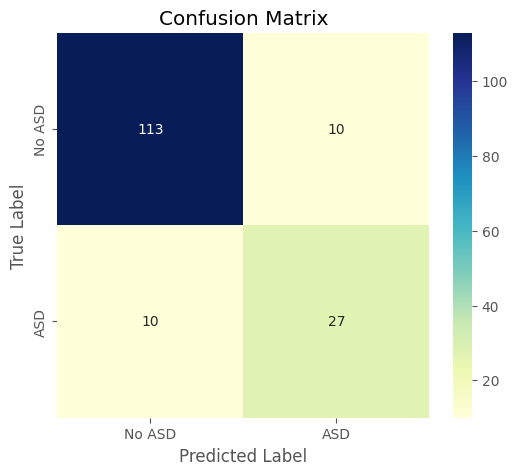

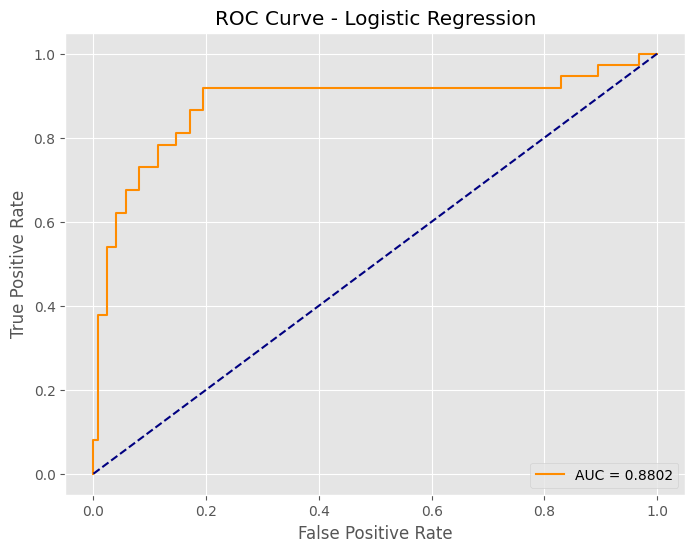

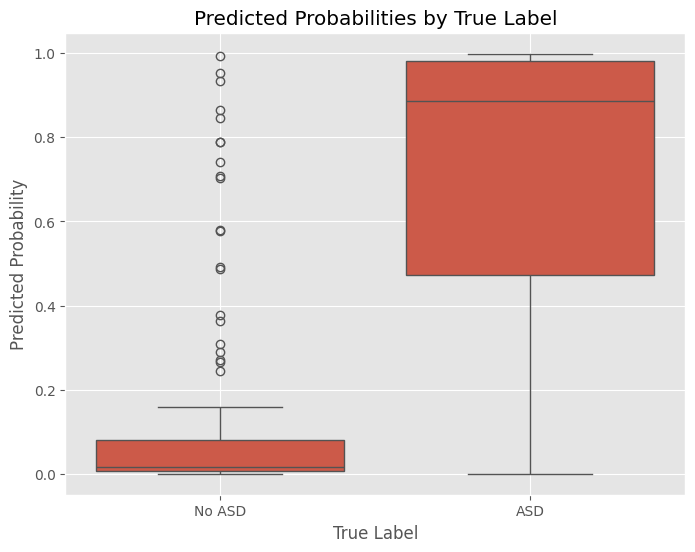

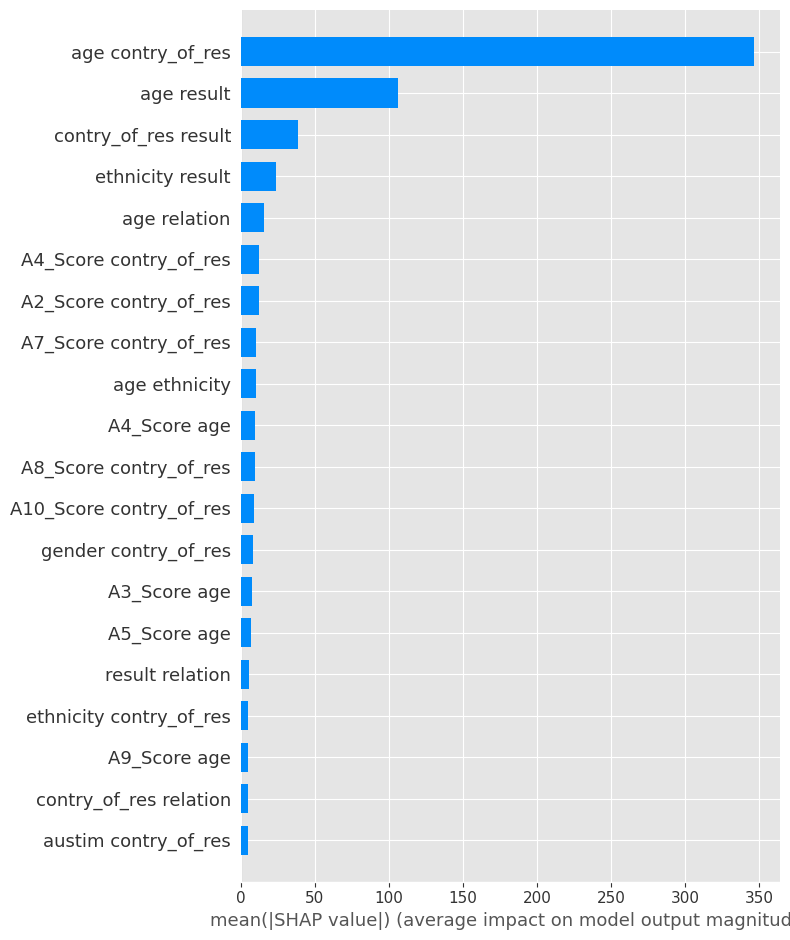


Top 10 Weighted Polynomial Features:
                 Feature  Coefficient
24     A1_Score A6_Score     1.414197
79    A4_Score A10_Score     1.105225
124   A7_Score ethnicity    -1.100911
171           age result    -0.990425
116      A6_Score result     0.978750
11                gender    -0.922230
157  A10_Score ethnicity     0.915239
27     A1_Score A9_Score    -0.885545
63    A3_Score A10_Score    -0.874656
28    A1_Score A10_Score    -0.861214

LaTeX Table for Top 10 Features:
\begin{tabular}{lr}
\toprule
Feature & Coefficient \\
\midrule
A1_Score A6_Score & 1.4142 \\
A4_Score A10_Score & 1.1052 \\
A7_Score ethnicity & -1.1009 \\
age result & -0.9904 \\
A6_Score result & 0.9788 \\
gender & -0.9222 \\
A10_Score ethnicity & 0.9152 \\
A1_Score A9_Score & -0.8855 \\
A3_Score A10_Score & -0.8747 \\
A1_Score A10_Score & -0.8612 \\
\bottomrule
\end{tabular}



In [3]:
# ================================
# COMPLETE ENHANCED LOGISTIC REGRESSION PIPELINE (with Polynomial Features + Threshold Tuning + SHAP + Feature Names + LaTeX Table)
# ================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score,
    precision_recall_curve
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load data
PATH = 'Autism-prediction'
train_data = pd.read_csv(os.path.join(PATH, 'train (1).csv'))
test_data = pd.read_csv(os.path.join(PATH, 'test.csv'))

train_data.drop_duplicates(inplace=True)
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Data preprocessing... [unchanged code hidden for brevity]

# Final encoding
categorical_cols_remaining = [col for col in all_data.select_dtypes(include='object').columns 
                             if col not in ['ID', 'Class/ASD']]
label_encoders = {}
for col in categorical_cols_remaining:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))
    label_encoders[col] = le

# Split back
enhanced_train = all_data.iloc[:len(train_data)].copy()
enhanced_test = all_data.iloc[len(train_data):].copy().reset_index(drop=True)

excluded_cols = ['ID', 'Class/ASD']
features = [col for col in enhanced_train.columns if col not in excluded_cols]
X = enhanced_train[features]
y = enhanced_train['Class/ASD']

# Feature selection
top_k = 20
selector = SelectKBest(score_func=f_classif, k=top_k)
X_selected = selector.fit_transform(X, y)
selected_features = [features[i] for i in selector.get_support(indices=True)]

# Polynomial expansion
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(enhanced_train[selected_features])
feature_names = poly.get_feature_names_out(selected_features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42))
])
pipeline.fit(X_train, y_train)

# Predict & threshold tuning
probs_test = pipeline.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, probs_test)
f1_scores = 2 * prec * rec / (prec + rec + 1e-10)
best_threshold = thresh[np.argmax(f1_scores)]

# Final predictions
final_preds_test = (probs_test >= best_threshold).astype(int)
final_preds_train = (pipeline.predict_proba(X_train)[:, 1] >= best_threshold).astype(int)

# Metrics
print("=== Evaluation Report ===")
print(f"Train Accuracy: {accuracy_score(y_train, final_preds_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, final_preds_test):.4f}")
print(f"Train ROC AUC: {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, probs_test):.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precision_score(y_test, final_preds_test):.4f}")
print(f"Recall: {recall_score(y_test, final_preds_test):.4f}")
print(f"F1 Score: {f1_score(y_test, final_preds_test):.4f}\n")
print(classification_report(y_test, final_preds_test, target_names=['No ASD', 'ASD']))

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc_score(y_test, probs_test):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Boxplot of Probabilities
prob_df = pd.DataFrame({'True Label': y_test, 'Predicted Probability': probs_test})
plt.figure(figsize=(8, 6))
sns.boxplot(x='True Label', y='Predicted Probability', data=prob_df)
plt.title('Predicted Probabilities by True Label')
plt.xticks([0, 1], ['No ASD', 'ASD'])
plt.grid(True)
plt.show()

# SHAP Analysis
explainer = shap.LinearExplainer(pipeline.named_steps['clf'], X_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, plot_type='bar')

# Top Polynomial Feature Names
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': pipeline.named_steps['clf'].coef_[0],
    'AbsCoeff': np.abs(pipeline.named_steps['clf'].coef_[0])
}).sort_values('AbsCoeff', ascending=False)

print("\nTop 10 Weighted Polynomial Features:")
print(coef_df.head(10)[['Feature', 'Coefficient']])

# Export LaTeX Table
latex_table = coef_df.head(10)[['Feature', 'Coefficient']].to_latex(index=False, float_format="%.4f")
print("\nLaTeX Table for Top 10 Features:")
print(latex_table)
